In [73]:
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [91]:
client = RemoteAPIClient()
sim = client.require('sim')

In [75]:
def Rx(rad:float) -> np.ndarray:
    """
    Função destinada a retornar a matriz de rotação em X
    :param: graus em radianos
    :return: a matriz de rotação
    """
    c = np.cos(rad)
    s = np.sin(rad)
    return np.array([[ 1 , 0 , 0 ],
                     [ 0 , c ,-s ],
                     [ 0 , s , c ]])

def Ry(rad:float) -> np.ndarray:
    """
    Função destinada a retornar a matriz de rotação em Y
    :param: graus em radianos
    :return: a matriz de rotação
    """
    c = np.cos(rad)
    s = np.sin(rad)
    return np.array([[ c , 0 , s ],
                     [ 0 , 1 , 0 ],
                     [-s , 0 , c ]])

def Rz(rad:float) -> np.ndarray:
    """
    Função destinada a retornar a matriz de rotação em Z
    :param: graus em radianos
    :return: a matriz de rotação
    """    
    c = np.cos(rad)
    s = np.sin(rad)
    return np.array([[ c ,-s , 0 ],
                     [ s , c , 0 ],
                     [ 0 , 0 , 1 ]])

def fullRotationMatrix(radX:float, radY:float, radZ:float) -> np.ndarray:
    """
    Função destinada a retornar a matriz de rotação em todos os eixos
    :param radX: graus em radianos no eixo X
    :param radY: graus em radianos no eixo Y
    :param radZ: graus em radianos no eixo Z
    :return: matriz de rotação em todos os eixos
    """
    return Rz(radZ) @ Ry(radY) @ Rx(radX)

In [76]:
def buildHomogeneousMatrix(rotationMatrix:np.ndarray, translationMatrix:np.ndarray) -> np.ndarray:
    """
    Função destinada a montar a matriz de tranformação homogenea
    :param rotationMatrix: matriz de rotação
    :param translationMatrix: matriz de translação
    :return: retorna a matriz de transformação homogênea
    """
    upperRows = np.concatenate([rotationMatrix, translationMatrix], axis = 1)
    lowerRow = np.array([[0, 0, 0, 1]])
    
    return np.concatenate([upperRows, lowerRow], axis = 0)

# Q.1

Reposta na cena

# Q.2

In [77]:
def calculateReferance(referentialObjectPath:str, otherObjectPath:str) -> np.ndarray:
    """
    Função destinada a calcular a posição de otherObject em relação a referentialObject
    :param referentialObjectPath: caminho para o objeto que será usado como referencial
    :param otherObjectPath: caminho para o objeto que será colocado sobre um novo referencial
    :return: a matriz de posição segundo o objeto de referência
    """
    referentialObject = sim.getObject(referentialObjectPath)
    otherObject = sim.getObject(otherObjectPath)

    refObjPos = np.array([sim.getObjectPosition(referentialObject)])
    refObjOrient = sim.getObjectOrientation(referentialObject)

    otherObjPos = np.array([sim.getObjectPosition(otherObject)])

    rotationMatrix = fullRotationMatrix(refObjOrient[0], refObjOrient[1], refObjOrient[2]).T
    
    translationMatrix = rotationMatrix @ -refObjPos.T

    homoMatrix = buildHomogeneousMatrix(rotationMatrix, translationMatrix)
    otherObjPos = np.concatenate([otherObjPos, np.array([[1]])], axis = 1)

    return homoMatrix @ otherObjPos.T

In [78]:
calculateReferance('/Pioneer_p3dx','/Bill')

array([[ 3.05      ],
       [ 2.        ],
       [-0.13879307],
       [ 1.        ]])

# Q.3

In [79]:
def calculateReferances(referentialObjectPath:str, otherObjectsPaths:list) -> list:
    """
    Função destinada a calcular a posição varios objetos sobre um novo referencial
    :param referentialObjectPath: caminho para o objeto que será usado como referencial
    :param otherObjectsPaths: lista de caminho para objetos que serão colocados sobre um novo referencial
    :return: uma lista de tuplas (caminho do objeto e a matriz de posição sobre novo referencial)
    """
    return [(otherObject, calculateReferance(referentialObjectPath, otherObject)) 
            for otherObject in otherObjectsPaths]

def plot2DView(objectsPositions:list, objectsNames:list = None, colors:list = ['r', 'b', 'g', 'm', 'k']) -> None:
    """
    Função destinada a plotar um gráfico visto de cima da posição dos objetos
    :param objectsPositions: uma lista de 
    """

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    if objectsNames:
        for position, name, color in zip(objectsPositions, objectsNames, colors):
            ax.plot(position[0], position[1], 'o', color = color, label = name)

    else:
        for position, color in zip(objectsPositions, colors):
            ax.plot(position[0], position[1], 'o', color = color)
    
    ax.axis((-7, 7, -7, 7))

    # Move left y-axis and bottom x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    if objectsNames:
        plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)
    plt.show()

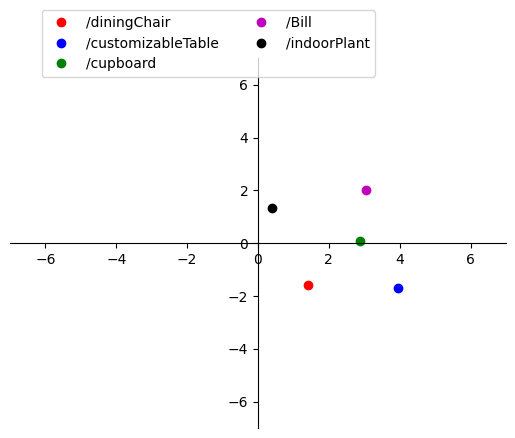

/diningChair :	 [ 1.42499937 -1.575       0.31120731]
/customizableTable :	 [ 3.95       -1.7         0.56120693]
/cupboard :	 [2.87499994 0.10000003 0.84620706]
/Bill :	 [ 3.05        2.         -0.13879307]
/indoorPlant :	 [0.40000006 1.35000012 0.02620704]


In [80]:
otherObjects = ['/diningChair', '/customizableTable', '/cupboard', '/Bill', '/indoorPlant']
robotName = '/Pioneer_p3dx'
robotRef = calculateReferances(robotName, otherObjects)
plot2DView([otherObject[1] for otherObject in robotRef], [otherObject[0] for otherObject in robotRef])
for name, matrix in robotRef:
    print(name, ':\t', matrix.T[0, :3])

# Q.4

X: 1.576 Y: -0.564 theta: 2


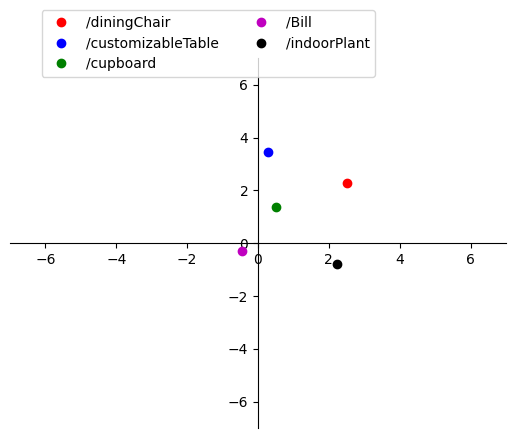

In [81]:
robot = sim.getObject(robotName)

x = 1.576
y = -.564
theta = 2

sim.setObjectPosition(robot, [x, y, 0.13879307])
sim.setObjectOrientation(robot, [.0, .0, theta])

print('X:', x, 'Y:', y, 'theta:', theta)

robotRef = calculateReferances(robotName, otherObjects)
plot2DView([otherObject[1] for otherObject in robotRef], [otherObject[0] for otherObject in robotRef])

X: -1.576 Y: 2.12 theta: -3.6


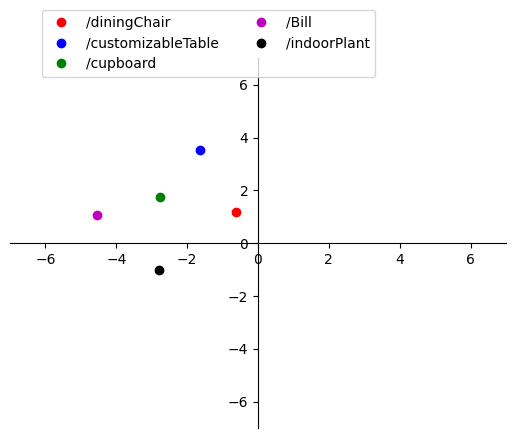

In [82]:
x = -1.576
y = 2.12
theta = -3.6

sim.setObjectPosition(robot, [x, y, 0.13879307])
sim.setObjectOrientation(robot, [.0, .0, theta])

print('X:', x, 'Y:', y, 'theta:', theta)

robotRef = calculateReferances(robotName, otherObjects)
plot2DView([otherObject[1] for otherObject in robotRef], [otherObject[0] for otherObject in robotRef])

X: 0 Y: 0 theta: 1.9


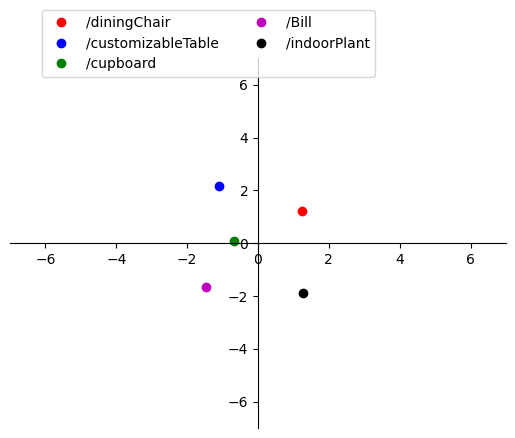

In [83]:
x = 0
y = 0
theta = 1.9

sim.setObjectPosition(robot, [x, y, 0.13879307])
sim.setObjectOrientation(robot, [.0, .0, theta])

print('X:', x, 'Y:', y, 'theta:', theta)

robotRef = calculateReferances(robotName, otherObjects)
plot2DView([otherObject[1] for otherObject in robotRef], [otherObject[0] for otherObject in robotRef])

In [84]:
robot = sim.getObject(robotName)

x = -0.29447179
y = 2.05000167
theta = -1.5707952037420654

sim.setObjectPosition(robot, [x, y, 0.13879307])
sim.setObjectOrientation(robot, [.0, .0, theta])

# Q.5

In [114]:
'''
readSensorData - It will try to capture the range and angle data from the simulator.
                 The request for the range data is sent in streaming mode to force
                 it to sync with the angle data request which acts as a mutex.

inputs:
    -range_data_signal_id: string containing the range data signal pipe name.
    -angle_data_signal_id: string containing the angle data signal pipe name.
outputs:
    -returns None if no data is recovered.
    -returns two arrays, one with data range and the other with their angles, if data was 
    retrieved successfully.
'''
def readSensorData(range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    string_range_data = sim.getStringSignal(range_data_signal_id)
    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # check the if both data were obtained correctly
    if string_range_data and string_angle_data :
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None


def draw_laser_data(laser_data, max_sensor_range=5):
    
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(x, y, 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)
        
    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

Program started
Connected to remote API server
[[-1.57079637  4.9994998 ]
 [-1.56785512  4.9994998 ]
 [-1.5648967   4.9994998 ]
 ...
 [ 1.5648967   4.9994998 ]
 [ 1.56785512  4.9994998 ]
 [ 1.57079637  4.9994998 ]]
Program ended


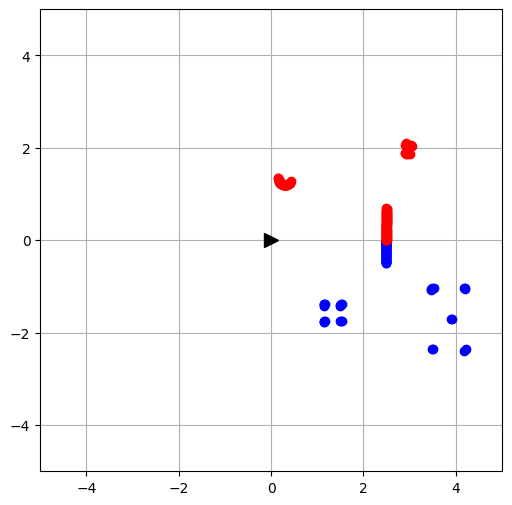

In [115]:
print ('Program started')
sim.startSimulation() # Connect to CoppeliaSim

print ('Connected to remote API server')

# Handle para o ROBÔ
robotname = '/Pioneer_p3dx'
sensor1Handle = sim.getObject(robotname)

# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')    

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

range_data = sim.getStringSignal(laser_range_data)

# Prosseguindo com as leituras
raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
laser_data = np.array([raw_angle_data, raw_range_data]).T

print(laser_data)
draw_laser_data(laser_data)

# Parando a simulação     
sim.stopSimulation()         
    
print ('Program ended')

# Q.6

In [112]:
print ('Program started')
sim.startSimulation() # Connect to CoppeliaSim

print ('Connected to remote API server')

# Handle para o ROBÔ    
robotname = '/Pioneer_p3dx'
sensor1Handle = sim.getObject(robotname)   

# Handle para as juntas das RODAS
l_wheel = sim.getObject(robotname + '_leftMotor')
r_wheel = sim.getObject(robotname + '_rightMotor')    

# Handle para os dados do LASER
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

# Dados do Pioneer
L = 0.381   # Metros
r = 0.0975  # Metros

t = 0
# Lembrar de habilitar o 'Real-time mode'
startTime=time.time()
lastTime = startTime

while t < 10:
    
    now = time.time()
    dt = now - lastTime

    # Fazendo leitura do laser   
    raw_range_data, raw_angle_data = readSensorData(laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    
    # Velocidade básica (linear, angular)
    v = .5
    w = np.deg2rad(0)      

    frente = int(len(laser_data)/2)
    lado_direito = int(len(laser_data)*1/4)
    lado_esquerdo = int(len(laser_data)*3/4)
    
    if laser_data[frente, 1] > 2:
        v = .5
        w = 0
    elif laser_data[lado_direito, 1] > 2:
        v = 0
        w = np.deg2rad(-30)
    elif laser_data[lado_esquerdo, 1] > 2:
        v = 0
        w = np.deg2rad(30)
    
    # Isso é o modelo cinemático, estudaremos detalhadamente depois!
    wl = v/r - (w*L)/(2*r)
    wr = v/r + (w*L)/(2*r)
    
    # Enviando velocidades
    sim.setJointTargetVelocity(l_wheel, wl)
    sim.setJointTargetVelocity(r_wheel, wr)        

    t = t + dt  
    lastTime = now

# Parando o robô    
sim.setJointTargetVelocity(r_wheel, 0)
sim.setJointTargetVelocity(l_wheel, 0)        
   
# Parando a simulação     
sim.stopSimulation()         
    
print ('Program ended')

Program started
Connected to remote API server
Program ended
